# Module 2
## Logistic Regression: Song Emotion

In [218]:
%matplotlib inline

import sys
PATH = '/Users/francescogemignani/Desktop/fma-proj'
sys.path.insert(0, PATH) 
from fma_metadata import utils

# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

from sklearn.ensemble import IsolationForest

#import random
from sklearn import preprocessing
#from sklearn.ensemble import IsolationForest
#from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Regression Libraries
#import statsmodels.api as sm
#from termcolor import colored as cl
#from sklearn.linear_model import LinearRegression, Ridge, Lasso
#from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error




import warnings
warnings.filterwarnings('ignore')

## A) Data Preprocess

### A.1) Import Dataset

In [219]:
echonest = utils.load("/Users/francescogemignani/Google Drive/DM2/_FMA/fma_metadata/echonest.csv")

In [220]:
echo = echonest['echonest','audio_features']
echo.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


We use valence how song emotion: if valence is greater to 0.5 that song is labeled as 'happy', otherwise 'sad'. How we can see the distribution of 'valence' is balanced

<AxesSubplot:>

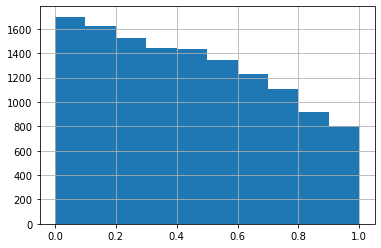

In [221]:
# distribution of valence
echo['valence'].hist()

In [222]:
# labeling valence 
echo['valence'] = echo['valence'].apply(lambda x: 'happy' if x>0.5 else 'sad')

In [223]:
# renaming valence as song_emotion
echo.rename({'valence': 'song_emotion'}, axis='columns', inplace=True)
echo.shape

(13129, 8)

In [224]:
echo['song_emotion'].value_counts()

sad      7724
happy    5405
Name: song_emotion, dtype: int64

In [225]:
# remove duplicate rows
echo.drop_duplicates(keep=False, inplace=True)

# remove Null values (if there are)
echo.dropna()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,song_emotion
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,happy
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,sad
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,happy
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,happy
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,happy
...,...,...,...,...,...,...,...,...
124857,0.007592,0.790364,0.719288,0.853114,0.720715,0.082550,141.332,happy
124862,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,sad
124863,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,sad


### A.2) Anomaly Detection

In [226]:
# encoding labels
le = preprocessing.LabelEncoder()
echo['song_emotion'] = le.fit_transform(echo['song_emotion'])

print(f"Legend\n1: Sad\n0: Happy")
echo.song_emotion.value_counts()

Legend
1: Sad
0: Happy


1    7724
0    5405
Name: song_emotion, dtype: int64

In [227]:
# transform data in an np.ndarray 
X = np.array(echo)

#isolation-forest sklearn version
F0 = IsolationForest(random_state=42, n_estimators=300, contamination=0.05).fit(X) 

# score isolation forest - sklearn
outliers_sk = F0.predict(X)

# IsolationForest Sklearn
echo['outlier_IF_sklearn'] = outliers_sk
echo['outlier_IF_sklearn'] = echo['outlier_IF_sklearn'].apply(lambda x: 'inlier' if x==1 else 'outlier')

# sklearn IF
print(f"**** Anomaly detected*****'")
print(echo['outlier_IF_sklearn'].value_counts())
print()

echo = echo[echo['outlier_IF_sklearn'] == 'inlier']
echo.drop('outlier_IF_sklearn',axis=1,inplace=True)

**** Anomaly detected*****'
inlier     12472
outlier      657
Name: outlier_IF_sklearn, dtype: int64



### A.3) Splitting Data

In [228]:
print(f"Legend\n1: Sad\n0: Happy")
echo.head()

Legend
1: Sad
0: Happy


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,song_emotion
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,1
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0


In [229]:
# remove labels from dataset 
labels = echo[['song_emotion']]
echo.drop('song_emotion', axis=1, inplace=True)

In [230]:
# split data in traning and test
X_train, X_test, y_train, y_test = train_test_split(echo, labels, test_size=0.30, random_state=42, stratify=labels,
                                                   shuffle=True) 

It is not correct to perform standardization before splitting the data. In general, you should not fit any preprocessing algorithm (PCA, StandardScaler...) on the whole dataset, but only on the training set, and use the fitted algorithm to transform the test set.

In [231]:
# normalize data
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

##### Visualize data in 2D with  PCA

In [232]:
from sklearn.decomposition import PCA
pca = PCA(2,random_state=42)
pca.fit(X_train)
pca_proj = pca.transform(X_train)

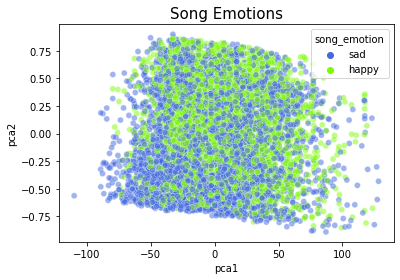

In [233]:
df = pd.DataFrame()
df['pca1'] = pca_proj[:,0]
df['pca2'] = pca_proj[:,1]
df['song_emotion'] = le.inverse_transform(y_train)
# plot scatter of PCA
plt.figure(figsize=(6,4))
sns.scatterplot(
    x="pca1", y="pca2",
    hue='song_emotion',
    palette={'happy':'lawngreen','sad':'royalblue'},
    data=df,
    c='black',
    legend="full",
    alpha=0.5
)
plt.title("Song Emotions", fontsize= 15)
plt.show()

## B) Logistic Regression Classifier